# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.use('TkAgg', warn = False)
from matplotlib import pyplot
import tensorflow as tf

In [2]:
import pickle

def load_pickled_data(file, columns):
    """
    Loads pickled training and test data.
    
    Parameters
    ----------
    file    : 
              Name of the pickle file.
    columns : list of strings, optional, defaults to `['features', 'labels']`
              List of columns in pickled data we're interested in.

    Returns
    -------
    A tuple of datasets for given columns.    
    """

    with open(file, mode='rb') as f:
        dataset = pickle.load(f)
    return tuple(map(lambda c: dataset[c], columns))

In [3]:
from pandas.io.parsers import read_csv

signnames = read_csv("signnames.csv").values[:, 1]

In [ ]:
train_dataset_file = "traffic-signs-data/train.p"
test_dataset_file = "traffic-signs-data/test.p"
train_balanced_dataset_file = "traffic-signs-data/train_balanced.p"

X_train, y_train, sizes, positions = load_pickled_data(train_dataset_file, ['features', 'labels', 'sizes', 'coords'])
X_test, y_test = load_pickled_data(test_dataset_file, ['features', 'labels'])

n_train = y_train.shape[0]
n_test = y_test.shape[0]
image_shape = X_train[0].shape
image_size = image_shape[0]
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)
n_classes = class_counts.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

### Original photos

Let's first explore data about original photos. Who knows — maybe we can spot some data correlations with signs positions in the photos or positions across specific sign classes.

Let's first plot histograms of original photos' sizes.

In [ ]:
width_fraction = (positions[:, 2] - positions[:, 0]) / sizes[:, 0]
height_fraction = (positions[:, 3] - positions[:, 1]) / sizes[:, 1]
sizes_figure = pyplot.figure(figsize = (10, 4))

axis = sizes_figure.add_subplot(1, 2, 1)
axis.hist(sizes[:, 0])
pyplot.title('Original photos\'s widths')
pyplot.xlabel('Width')
pyplot.ylabel('Photos')

axis = sizes_figure.add_subplot(1, 2, 2)
axis.hist(sizes[:, 1])
pyplot.title('Original photos\'s heights')
pyplot.xlabel('Height')
pyplot.ylabel('Photos')

pyplot.show()

Doesn't look too promising — apparently photos are of all different sizes, majority ranging from ~30 to ~150 px both width and height. Actually both histograms looks surprisingly similar, I bet aspect ratios of all photos are close to 1. Let's check it out!

In [ ]:
sizes_figure = pyplot.figure()
axis = sizes_figure.add_subplot(1, 1, 1)
axis.hist(sizes[:, 0]/sizes[:, 1])
pyplot.title('Photos\' aspect ratios distribution')
pyplot.xlabel('Aspect ratio')
pyplot.ylabel('Photos')
pyplot.show()

There you go! Vast majority of original photos had aspect ratio ranging from 0.9 to 1.2, e.g. almost all photos were more or less square.

Let's check how much area of the original image did signs occupy? In other words, to which extent did we have to crop the original photo to get the sign out of it. Again, let's check for both width and height by calculating sign dimensions as fractions of original photo dimensions.

In [ ]:
width_fraction = (positions[:, 2] - positions[:, 0]) / sizes[:, 0]
height_fraction = (positions[:, 3] - positions[:, 1]) / sizes[:, 1]

sizes_figure = pyplot.figure(figsize = (10, 4))

axis = sizes_figure.add_subplot(1, 2, 1)
axis.hist(width_fraction)
pyplot.title('Sign width / original photo width')
pyplot.xlabel('Width fraction')
pyplot.ylabel('Photos')

axis = sizes_figure.add_subplot(1, 2, 2)
axis.hist(height_fraction)
pyplot.title('Sign height / original photo height')
pyplot.xlabel('Height fraction')
pyplot.ylabel('Photos')

pyplot.show()

In [ ]:
from scipy import stats

def print_stats(array, label):
    _, minmax, mean, variance, _, _ = stats.describe(array)
    margin = int((40 - len(label)) / 2)
    for i in range(margin * 2): 
        if i == margin: print(label.upper(), end="")
        print("=", end="")    
    print()

    print("  %-*s %s" % (15, "Min:", str(minmax[0])))
    print("  %-*s %s" % (15, "Max:", str(minmax[1])))
    print("  %-*s %s" % (15, "Mean:", str(mean)))
    print("  %-*s %s" % (15, "Variance:", str(variance)))
    
    print()
    
print_stats(width_fraction, " sign_width / photo_width ")
print_stats(height_fraction, " sign_height / photo_height ")

Not really promising either. All photos had almost nothing but signs in them, for both width and height signs occupied at least half of the dimension, and for majority of samples signs occupied around 75% of the photo.

Now, if we found any uneven distributions in the dataset I would be tempted to try and analyze it on per-class basis. Although for now data looks pretty homogeneous and I doubt there will be any meaningful patterns related to specific classes based on the original samples' images.

### Sample images

Ok, let's check out the sign samples. We will go through all dataset classes, noting number of samples and plotting 10 random images representing each class.

In [ ]:
import random

col_width = max(len(name) for name in signnames)

for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print("Class %i: %-*s  %s samples" % (c, col_width, signnames[c], str(c_count)))
    fig = pyplot.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_indices[i]])
    pyplot.show()
    print("--------------------------------------------------------------------------------------\n")

**Bad news**: Some classes are highly underrepresented. Overall amount of data is disappointing: some classes have as little as 210 samples, this won't be enough for most of the models to generalise well.

**Good news**: There is a room for data augmentation.

Images with some signs are horizontally symmetrical (like **Bumpy road** or **Ahead only**), and can be simply flipped horizontally, thus allowing us to get twice as much data for these classes. 

Other signs come in kind of interchageable pairs, like **Keep right** and **Keep left**: those signs can be flipped and assigned to a paired class. In some cases (like **Keep right** and **Keep left**) we increase the number of samples for **Keep left** from 300 to 2370!

CNNs have built-in invariance to small translations, scaling and rotations. The training set doesn't seem to contain those deformations, so we will add those in our data augmentation step as well.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

In [280]:
import sys

# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()


In [309]:
from sklearn.utils import shuffle
from skimage import exposure
import warnings 

num_classes = 43

def preprocess_dataset(X, y = None):
    """
    Performs feature scaling, one-hot encoding of labels and shuffles the data if labels are provided.
    Assumes original dataset is sorted by labels.
    
    Parameters
    ----------
    X                : ndarray
                       Dataset array containing feature examples.
    y                : ndarray, optional, defaults to `None`
                       Dataset labels in index form.
    Returns
    -------
    A tuple of X and y.    
    """
    print("Preprocessing dataset with {} examples:".format(X.shape[0]))

    #Convert to grayscale, e.g. single channel Y
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    #Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)
        
    for i in range(X.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X[i] = exposure.equalize_adapthist(X[i])
            #X[i] = exposure.equalize_hist(X[i])
        print_progress(i + 1, X.shape[0])
        
    if y is not None:  
        # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
        y = np.eye(num_classes)[y]
        X, y = shuffle(X, y, random_state = 42)

    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X, y

def class_name(one_hot):
    return signnames[one_hot.nonzero()[0][0]]

def load_and_process_data(pickled_data_file):
    """
    Loads pickled data and preprocesses images and labels by scaling features, 
    shuffling the data and applying one-hot encoding to labels.
    
    Parameters
    ----------
    pickled_data_file  : string
                         Pickled data file name.
    Returns
    -------
    A tuple of X and y containing preloaded and preprocessed features and labels respectively.    
    """
    X, y = load_pickled_data(pickled_data_file, columns = ['features', 'labels'])
    X, y = preprocess_dataset(X, y)
    return (X, y)

Data augmentation.

In [134]:
from nolearn.lasagne import BatchIterator
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
from skimage.util import random_noise
from skimage.exposure import adjust_gamma
from skimage.filters import gaussian
import random

class AugmentedSignsBatchIterator(BatchIterator):
    """
    Iterates over dataset in batches. 
    Allows images augmentation by randomly rotating, applying projection, 
    adjusting gamma, blurring, adding noize and flipping horizontally.
    """
        
    def __init__(self, batch_size, shuffle = False, seed = 42, p = 0.5, intensity = 0.5):
        """
        Initialises an instance with usual iterating settings, as well as data augmentation coverage
        and augmentation intensity.
        
        Parameters
        ----------
        batch_size:
                    Size of the iteration batch.
        shuffle   :
                    Flag indicating if we need to shuffle the data.
        seed      :
                    Random seed.
        p         :
                    Probability of augmenting a single example, should be in a range of [0, 1] .
                    Defines data augmentation coverage.
        intensity :
                    Augmentation intensity, should be in a [0, 1] range.
        
        Returns
        -------
        New batch iterator instance.
        """
        super(AugmentedSignsBatchIterator, self).__init__(batch_size, shuffle, seed)
        self.p = p
        self.intensity = intensity

    def transform(self, Xb, yb):
        """
        Applies a pipeline of randomised transformations for data augmentation.
        """
        Xb, yb = super(AugmentedSignsBatchIterator, self).transform(
            Xb if yb is None else Xb.copy(), 
            yb
        )
        
        if yb is not None:
            batch_size = Xb.shape[0]
            image_size = Xb.shape[1]
            
            Xb = self.rotate(Xb, batch_size)
            Xb = self.apply_projection_transform(Xb, batch_size, image_size)
            Xb = self.adjust_gamma(Xb, batch_size)
            Xb = self.blur(Xb, batch_size)
            #Xb = self.add_noise(Xb, batch_size)

        return Xb, yb
        
    def rotate(self, Xb, batch_size):
        """
        Applies random rotation in a defined degrees range to a random subset of images. 
        Range itself is subject to scaling depending on augmentation intensity.
        """
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):
            delta = 30. * self.intensity # scale by self.intensity
            Xb[i] = rotate(Xb[i], random.uniform(-delta, delta), mode = 'edge')
        return Xb 
    
    def add_noise(self, Xb, batch_size):
        """
        Adds random noise to a random subset of images.
        """
        modes = ["gaussian", "localvar", "poisson", "speckle"] # Excluding "salt", "pepper", "s&p" for now
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):
            Xb[i] = random_noise(Xb[i], mode = random.choice(modes))
        return Xb
    
    def adjust_gamma(self, Xb, batch_size):
        """
        Applies gamma adjustment to a random subset of images, updating gamma with a random value in the defined range. 
        Range itself is subject to scaling depending on augmentation intensity.
        """
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):
            delta = 0.8 * self.intensity
            Xb[i] = adjust_gamma(Xb[i], gamma = random.uniform(1. - delta, 1. + delta))
        return Xb        

    def blur(self, Xb, batch_size):
        """
        Applies gaussian blur with a random sigma in the defined range to a random subset of images.
        Range itself is subject to scaling depending on augmentation intensity.
        """
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):
            max_sigma = 0.5 * self.intensity
            Xb[i] = gaussian(Xb[i], sigma = random.uniform(0., max_sigma), multichannel = Xb.shape[3] == 3)
        return Xb   
    
    def apply_projection_transform(self, Xb, batch_size, image_size):
        """
        Applies projection transform to a random subset of images. Projection margins are randomised in a range
        depending on the size of the image. Range itself is subject to scaling depending on augmentation intensity.
        """
        d = image_size * 0.3 * self.intensity
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):        
            tl_top = random.uniform(-d, d)     # Top left corner, top margin
            tl_left = random.uniform(-d, d)    # Top left corner, left margin
            bl_bottom = random.uniform(-d, d)  # Bottom left corner, bottom margin
            bl_left = random.uniform(-d, d)    # Bottom left corner, left margin
            tr_top = random.uniform(-d, d)     # Top right corner, top margin
            tr_right = random.uniform(-d, d)   # Top right corner, right margin
            br_bottom = random.uniform(-d, d)  # Bottom right corner, bottom margin
            br_right = random.uniform(-d, d)   # Bottom right corner, right margin

            transform = ProjectiveTransform()
            transform.estimate(np.array((
                    (tl_left, tl_top),
                    (bl_left, image_size - bl_bottom),
                    (image_size - br_right, image_size - br_bottom),
                    (image_size - tr_right, tr_top)
                )), np.array((
                    (0, 0),
                    (0, image_size),
                    (image_size, image_size),
                    (image_size, 0)
                )))
            Xb[i] = warp(Xb[i], transform, output_shape=(image_size, image_size), order = 1, mode = 'edge')

        return Xb

Class: Traffic signals


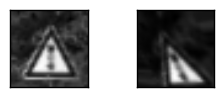

Class: No vechiles


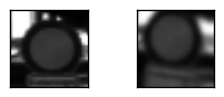

Class: Yield


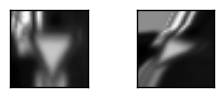

Class: No passing for vechiles over 3.5 metric tons


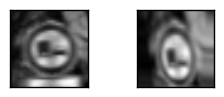

Class: No vechiles


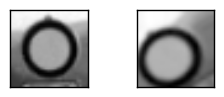

Class: Priority road


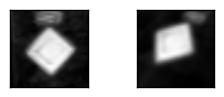

Class: Road work


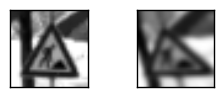

Class: Speed limit (50km/h)


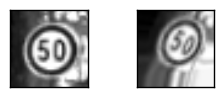

Class: Right-of-way at the next intersection


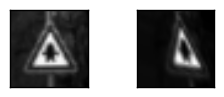

Class: Ahead only


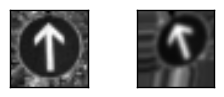

Class: Speed limit (50km/h)


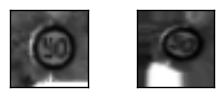

Class: No passing


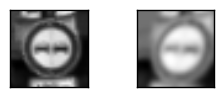

Class: Yield


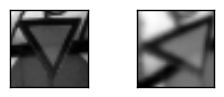

Class: Traffic signals


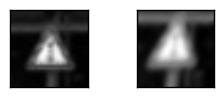

Class: Speed limit (30km/h)


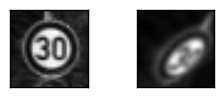

Class: Wild animals crossing


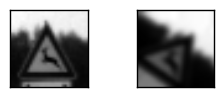

Class: Speed limit (50km/h)


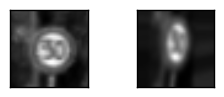

Class: Speed limit (80km/h)


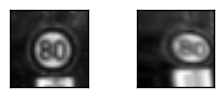

Class: Road narrows on the right


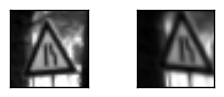

Class: No passing for vechiles over 3.5 metric tons


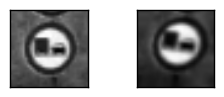

In [73]:
X_train, y_train = load_and_process_data("traffic-signs-data/train.p")

batch_iterator = AugmentedSignsBatchIterator(batch_size = 20, p = 1.0, intensity = 1.)
for x_batch, y_batch in batch_iterator(X_train, y_train):
    for i in range(20): 
        print("Class: " + class_name(y_batch[i]))
        # plot two images:
        fig = pyplot.figure(figsize=(3, 1))
        axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
        axis.imshow(X_train[i].reshape(32, 32), cmap='gray')
        axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
        axis.imshow(x_batch[i].reshape(32, 32), cmap='gray')
        pyplot.show()
    break

A couple of functions for preprocessing our dataset. We may only need to call them once, then pickle resulting balanced dataset and keep using that pickle from then on.

In [182]:
import sys

def extend_flipping_horizontally(X, y):
    """
    Extends existing images dataset by flipping images of some classes. As some images would still belong
    to same class after horizontal flipping we extend such classes with flipped images. Images of other
    classes would toggle between two classes when flipped, so for those we extend existing datasets as
    well.
    
    Parameters
    ----------
    X       : ndarray
              Dataset array containing feature examples.
    y       : ndarray, optional, defaults to `None`
              Dataset labels in index form.

    Returns
    -------
    A tuple of X and y.    
    """
    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped horizontally, should still be classified as some other class
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39],
        [20, 19], 
        [34, 33], 
        [37, 36], 
        [39, 38],   
    ])
    num_classes = 43
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    
    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis = 0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
    
    return (X_extended, y_extended)

# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

def extend_balancing_classes(X, y, aug_intensity = 0.5, counts = None):
    """
    Extends dataset by duplicating existing images while applying data augmentation pipeline.
    Number of generated examples for each class may be provided in `counts`.
    
    Parameters
    ----------
    X             : ndarray
                    Dataset array containing feature examples.
    y             : ndarray, optional, defaults to `None`
                    Dataset labels in index form.
    aug_intensity :
                    Intensity of augmentation, must be in [0, 1] range.
    counts        :
                    Number of elements for each class.
                    
    Returns
    -------
    A tuple of X and y.    
    """
    num_classes = 43

    _, class_counts = np.unique(y, return_counts = True)
    max_c = max(class_counts)
    total = max_c * num_classes if counts is None else np.sum(counts)
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = np.float32)
    y_extended = np.empty([0], dtype = y.dtype)
    print("Extending dataset using augmented data (intensity = {}):".format(aug_intensity))
    
    for c, c_count in zip(range(num_classes), class_counts):
        # How many examples should there be eventually for this class:
        max_c = max_c if counts is None else counts[c]
        # First copy existing data for this class
        X_source = (X[y == c] / 255.).astype(np.float32)
        y_source = y[y == c]
        X_extended = np.append(X_extended, X_source, axis = 0)
        for i in range((max_c // c_count) - 1):
            batch_iterator = AugmentedSignsBatchIterator(batch_size = X_source.shape[0], p = 1.0, intensity = aug_intensity)
            for x_batch, _ in batch_iterator(X_source, y_source):
                X_extended = np.append(X_extended, x_batch, axis = 0)
                print_progress(X_extended.shape[0], total)
        batch_iterator = AugmentedSignsBatchIterator(batch_size = max_c % c_count, p = 1.0, intensity = aug_intensity)
        for x_batch, _ in batch_iterator(X_source, y_source):
            X_extended = np.append(X_extended, x_batch, axis = 0)
            print_progress(X_extended.shape[0], total)
            break
        # Fill labels for added images set to current class.
        added = X_extended.shape[0] - y_extended.shape[0]
        y_extended = np.append(y_extended, np.full((added), c, dtype = int))
        
    return ((X_extended * 255.).astype(np.uint8), y_extended)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

I convert images to grayscale, scale to `[0, 1]` and shuffle the datasets.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I decided to use a 20% slice of training data for validation. Normally I would split entire dataset as 70% training, 15% validation, 15% testing, but since here test dataset was supplied separately I assumed it's better to use all of it solely for testing.

The dataset looked quite small and some classes were significantly less represented than others, so I reckon the model wouldn't generalise well without additional examples. I decided to use data augmentation by applying randomised transformations while supplying batches of training data to the model. I find Lasagne's `BatchIterator` class very convenient, as one can simply override the `transform()` function and provide their data augmentation pipeline there.

So that's what I did, my pipeline includes:
* **Rotation**. Rotates the image at a random angle in the range of `[-15, 15]` degrees.
* **Projection transform**. Warps the image by projecting each of the image corners to a random point within a 10% of image size distance from the original point.
* **Gamma adjustment**. Adjusts image brightness/contrast by applying gamma adjustment in the range of `[0.5, 1.5]`.
* **Blur**. Applies gaussian blur with sigma in the range of `[0, 0.8]`.
* **Noise**. Adds random noise to the image. I've switched it off for now, but might experiment with it later.
* Last but not least, **horizontal flip**. Flips images horizontally if their class would remain the same, *OR* flips and updates the label, if flipped image represents some other class (e.g. flipped *Turn left* sign would become *Turn right*).

I chose these transformations as they seemed to be close to what we could see on the photos. Image could be blurred and/or noisy due to low resolution source photo, it can be either too bright or too dark depending on the outside conditions, and it can look rotated and/or projection warped on the photo depending on the shooting angle.

Struct to organise some of the model parameters.

In [206]:
from collections import namedtuple

Parameters = namedtuple('Parameters', [
        # Data parameters
        'num_classes', 'image_size', 
        # Training parameters
        'batch_size', 'max_epochs', 'log_epoch', 'print_epoch',
        # Optimisations
        'learning_rate_decay', 'learning_rate',
        'l2_reg_enabled', 'l2_lambda', 
        'early_stopping_enabled', 'early_stopping_patience', 
        'resume_training', 
        # Layers architecture
        'conv1_k', 'conv1_d', 'conv1_p', 
        'conv2_k', 'conv2_d', 'conv2_p', 
        'conv3_k', 'conv3_d', 'conv3_p', 
        'fc4_size', 'fc4_p',
        'fc5_size', 'fc5_p'
    ])

General routines

In [231]:
import time
import os

def get_time_hhmmss(start = None):
    """
    Calculates time since `start` and formats as a string.
    """
    if start is None:
        return time.strftime("%Y/%m/%d %H:%M:%S")
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str   

class Paths(object):
    """
    Provides easy access to common paths we use for persisting 
    the data associated with model training.
    """
    
    def __init__(self, params):
        """
        Initialises a new `Paths` instance and creates corresponding folders if needed.

        Parameters
        ----------
        params  : Parameters
                  Structure (`namedtuple`) containing model parameters.
        """
        self.model_name = self.get_model_name(params)
        self.var_scope = self.get_variables_scope(params)
        self.root_path = os.getcwd() + "/models/" + self.model_name + "/"
        self.model_path = self.get_model_path()
        self.train_history_path = self.get_train_history_path()
        self.learning_curves_path = self.get_learning_curves_path()
        os.makedirs(self.root_path, exist_ok = True)

    def get_model_name(self, params):
        """
        Generates a model name with some of the crucial model parameters encoded into the name.

        Parameters
        ----------
        params  : Parameters
                  Structure (`namedtuple`) containing model parameters.
                  
        Returns
        -------
        Model name.
        """
        # We will encode model settings in its name: architecture, optimisations applied, etc.
        model_name = "k{}d{}p{}_k{}d{}p{}_k{}d{}p{}_fc{}p{}_fc{}p{}".format(
            params.conv1_k, params.conv1_d, params.conv1_p, 
            params.conv2_k, params.conv2_d, params.conv2_p, 
            params.conv3_k, params.conv3_d, params.conv3_p, 
            params.fc4_size, params.fc4_p,
            params.fc5_size, params.fc5_p
        )
        model_name += "_lrdec" if params.learning_rate_decay else "_no-lrdec"
        model_name += "_l2" if params.l2_reg_enabled else "_no-l2"
        return model_name

    def get_variables_scope(self, params):
        """
        Generates a model variable scope with some of the crucial model parameters encoded.

        Parameters
        ----------
        params  : Parameters
                  Structure (`namedtuple`) containing model parameters.
                  
        Returns
        -------
        Variables scope name.
        """
        # We will encode model settings in its name: architecture, optimisations applied, etc.
        var_scope = "k{}d{}_k{}d{}_k{}d{}_fc{}_fc{}".format(
            params.conv1_k, params.conv1_d,
            params.conv2_k, params.conv2_d,
            params.conv3_k, params.conv3_d, 
            params.fc4_size,
            params.fc5_size
        )
        return var_scope

    def get_model_path(self):
        """
        Generates path to the model file.
   
        Returns
        -------
        Model file path.
        """
        return self.root_path + "model.ckpt"

    def get_train_history_path(self):
        """
        Generates path to the train history file.
   
        Returns
        -------
        Train history file path.
        """
        return self.root_path + "train_history"
    
    def get_learning_curves_path(self):
        """
        Generates path to the learning curves graph file.
   
        Returns
        -------
        Learning curves file path.
        """
        return self.root_path + "learning_curves.png"

Early stopping.

In [162]:
class EarlyStopping(object):
    """
    Provides early stopping functionality. Keeps track of model accuracy, 
    and if it doesn't improve over time restores last best performing 
    parameters.
    """
    
    def __init__(self, saver, session, patience = 100, minimize = True):
        """
        Initialises a `EarlyStopping` isntance.

        Parameters
        ----------
        saver     : 
                    TensorFlow Saver object to be used for saving and restoring model.
        session   : 
                    TensorFlow Session object containing graph where model is restored.
        patience  : 
                    Early stopping patience. This is the number of epochs we wait for 
                    accuracy to start improving again before stopping and restoring 
                    previous best performing parameters.
                  
        Returns
        -------
        New instance.
        """
        self.minimize = minimize
        self.patience = patience
        self.saver = saver
        self.session = session
        self.best_monitored_value = np.inf if minimize else 0.
        self.best_monitored_epoch = 0
        self.restore_path = None

    def __call__(self, value, epoch):
        """
        Checks if we need to stop and restores the last well performing values if we do.

        Parameters
        ----------
        value      : 
                    Last epoch monitored value.
        epoch     : 
                    Last epoch number.
                  
        Returns
        -------
        `True` if we waited enough and it's time to stop and we restored the 
        best performing weights, or `False` otherwise.
        """
        if (self.minimize and value < self.best_monitored_value) or (not self.minimize and value > self.best_monitored_value):
            self.best_monitored_value = value
            self.best_monitored_epoch = epoch
            self.restore_path = self.saver.save(self.session, os.getcwd() + "/early_stopping_checkpoint")
        elif self.best_monitored_epoch + self.patience < epoch:
            if self.restore_path != None:
                self.saver.restore(self.session, self.restore_path)
            else:
                print("ERROR: Failed to restore session")
            return True
        
        return False

Logger to keep track of the training even if no browser is connected to kernel.

In [232]:
from cloudlog import CloudLog

class ModelCloudLog(CloudLog):
        
    def log_parameters(self, params, train_size, valid_size, test_size):
        """
        Logs model parameters to console and appends the same text representation to the log file.

        Parameters
        ----------
        params    : Parameters
                    Structure (`namedtuple`) containing model parameters.
        train_size: int
                    Size of the training dataset.
        valid_size: int
                    Size of the training dataset.
        test_size : int
                    Size of the training dataset.
        """
        if params.resume_training:
            self("=============================================")
            self("============= RESUMING TRAINING =============")
            self("=============================================")

        self("=================== DATA ====================")
        self("            Training set: {} examples".format(train_size))
        self("          Validation set: {} examples".format(valid_size))
        self("             Testing set: {} examples".format(test_size))
        self("              Batch size: {}".format(params.batch_size))   

        self("=================== MODEL ===================")
        self("--------------- ARCHITECTURE ----------------")  
        self(" %-*s %-*s %-*s %-*s" % (10, "", 10, "Type", 8, "Size", 15, "Dropout (keep p)"))    
        self(" %-*s %-*s %-*s %-*s" % (10, "Layer 1", 10, "{}x{} Conv".format(params.conv1_k, params.conv1_k), 8, str(params.conv1_d), 15, str(params.conv1_p)))    
        self(" %-*s %-*s %-*s %-*s" % (10, "Layer 2", 10, "{}x{} Conv".format(params.conv2_k, params.conv2_k), 8, str(params.conv2_d), 15, str(params.conv2_p)))    
        self(" %-*s %-*s %-*s %-*s" % (10, "Layer 3", 10, "{}x{} Conv".format(params.conv3_k, params.conv3_k), 8, str(params.conv3_d), 15, str(params.conv3_p)))    
        self(" %-*s %-*s %-*s %-*s" % (10, "Layer 4", 10, "FC", 8, str(params.fc4_size), 15, str(params.fc4_p)))    
        self(" %-*s %-*s %-*s %-*s" % (10, "Layer 5", 10, "FC", 8, str(params.fc5_size), 15, str(params.fc5_p)))    
        self("---------------- PARAMETERS -----------------")
        self("     Learning rate decay: " + ("Enabled" if params.learning_rate_decay else "Disabled (rate = {})".format(params.learning_rate)))
        self("       L2 Regularization: " + ("Enabled (lambda = {})".format(params.l2_lambda) if params.l2_reg_enabled else "Disabled"))
        self("          Early stopping: " + ("Enabled (patience = {})".format(params.early_stopping_patience) if params.early_stopping_enabled else "Disabled"))
        self(" Keep training old model: " + ("Enabled" if params.resume_training else "Disabled")) 

Model architecture

In [224]:
def fully_connected(input, size):
    """
    Performs a single fully connected layer pass, e.g. returns `input * weights + bias`.
    """
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
        #initializer = tf.truncated_normal_initializer(stddev=0.01)
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer = tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

def conv_relu(input, kernel_size, depth):
    """
    Performs a single convolution layer pass.
    """
    weights = tf.get_variable( 'weights', 
        shape = [kernel_size, kernel_size, input.get_shape()[3], depth],
        initializer = tf.contrib.layers.xavier_initializer()
        #initializer = tf.truncated_normal_initializer(stddev=0.01)
      )
    biases = tf.get_variable( 'biases',
        shape = [depth],
        initializer = tf.constant_initializer(0.0)
      )
    conv = tf.nn.conv2d(input, weights,
        strides = [1, 1, 1, 1], padding = 'SAME')
    return tf.nn.relu(conv + biases)

def pool(input, size):
    """
    Performs a max pooling layer pass.
    """
    return tf.nn.max_pool(
        input, 
        ksize = [1, size, size, 1], 
        strides = [1, size, size, 1], 
        padding = 'SAME'
    )

def model_pass(input, params, training):
    """
    Performs a full model pass.
    """
    # Convolutions

    with tf.variable_scope('conv1'):
        conv1 = conv_relu(input, kernel_size = params.conv1_k, depth = params.conv1_d) 
    with tf.variable_scope('pool1'): 
        pool1 = pool(conv1, size = 2)
        pool1 = tf.cond(training, lambda: tf.nn.dropout(pool1, keep_prob = params.conv1_p), lambda: pool1)
    with tf.variable_scope('conv2'):
        conv2 = conv_relu(pool1, kernel_size = params.conv2_k, depth = params.conv2_d)
    with tf.variable_scope('pool2'):
        pool2 = pool(conv2, size = 2)
        pool2 = tf.cond(training, lambda: tf.nn.dropout(pool2, keep_prob = params.conv2_p), lambda: pool2)
    with tf.variable_scope('conv3'):
        conv3 = conv_relu(pool2, kernel_size = params.conv3_k, depth = params.conv3_d)
    with tf.variable_scope('pool3'):
        pool3 = pool(conv3, size = 2)
        pool3 = tf.cond(training, lambda: tf.nn.dropout(pool3, keep_prob = params.conv3_p), lambda: pool3)
    
    # Fully connected
    
    # 1st stage output
    shape = pool3.get_shape().as_list()
    pool3 = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])
    
    # 2nd stage output
    shape = pool1.get_shape().as_list()
    pool1 = tf.reshape(pool1, [-1, shape[1] * shape[2] * shape[3]])
    flattened = tf.concat(1, [pool1, pool3])
    
    with tf.variable_scope('fc4'):
        fc4 = fully_connected(flattened, size = params.fc4_size)
        fc4 = tf.cond(training, lambda: tf.nn.dropout(fc4, keep_prob = params.fc4_p), lambda: fc4)
#     with tf.variable_scope('fc5'):
#         fc5 = fully_connected(fc4, size = params.fc5_size)
#         fc5 = tf.cond(training, lambda: tf.nn.dropout(fc5, keep_prob = params.fc5_p), lambda: fc5)
    with tf.variable_scope('out'):
        prediction = fully_connected(fc4, size = params.num_classes)
    return prediction

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [165]:
def plot_curve(axis, params, train_column, valid_column, linewidth = 2, train_linestyle = "b-", valid_linestyle = "g-"):
    model_history = np.load(Paths(params).train_history_path + ".npz")
    train_values = model_history[train_column]
    valid_values = model_history[valid_column]
    epochs = train_values.shape[0]
    x_axis = np.arange(epochs)
    axis.plot(x_axis[train_values > 0], train_values[train_values > 0], train_linestyle, linewidth=linewidth, label="train")
    axis.plot(x_axis[valid_values > 0], valid_values[valid_values > 0], valid_linestyle, linewidth=linewidth, label="valid")
    return epochs

# Plots history of learning curves for a specific model..
def plot_learning_curves(params):
    curves_figure = pyplot.figure(figsize = (10, 4))
    axis = curves_figure.add_subplot(1, 2, 1)
    epochs_plotted = plot_curve(axis, parameters, train_column = "train_accuracy_history", valid_column = "valid_accuracy_history")

    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("accuracy")
    pyplot.ylim(50., 115.)
    pyplot.xlim(0, epochs_plotted)#max(new_model_epochs, old_model_epochs))

    axis = curves_figure.add_subplot(1, 2, 2)
    epochs_plotted = plot_curve(axis, parameters, train_column = "train_loss_history", valid_column = "valid_loss_history")

    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("loss")
    pyplot.ylim(0.0001, 10.)
    pyplot.xlim(0, epochs_plotted)
    pyplot.yscale("log")

In [229]:
def train_model(params, X_train, y_train, X_valid, y_valid, X_test, y_test, logger_config):
    """
    Performs model training based on provided training dataset 
    according to provided parameters, and then evaluates trained 
    model with testing dataset. 
    Part of the training dataset may be used for validation during
    training if specified in model parameters.

    Parameters
    ----------
    params    : Parameters
                Structure (`namedtuple`) containing model parameters.
    X_train   : 
                Training dataset. 
    y_train   : 
                Training dataset labels. 
    X_valid   : 
                Validation dataset. 
    y_valid   : 
                Validation dataset labels. 
    X_test    : 
                Testing dataset. 
    y_test    : 
                Testing dataset labels. 
    """
    
    # Initialisation routines: generate variable scope, create logger, note start time.
    paths = Paths(params)
    log = ModelCloudLog(
        os.path.join(paths.root_path, "logs"), 
        dropbox_token=logger_config["dropbox_token"], 
        telegram_token=logger_config["telegram_token"], 
        telegram_chat_id=logger_config["telegram_chat_id"]
    )
    start = time.time()
    model_variable_scope = paths.var_scope

    log.log_parameters(params, y_train.shape[0], y_valid.shape[0], y_test.shape[0]) 
    
    # Build the graph
    graph = tf.Graph()
    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        tf_x_batch = tf.placeholder(tf.float32, shape = (None, params.image_size[0], params.image_size[1], 1))
        tf_y_batch = tf.placeholder(tf.float32, shape = (None, params.num_classes))
        is_training = tf.placeholder(tf.bool)
        current_epoch = tf.Variable(0, trainable=False)  # count the number of epochs

        # Model parameters.
        if params.learning_rate_decay:
            learning_rate = tf.train.exponential_decay(params.learning_rate, current_epoch, decay_steps = params.max_epochs, decay_rate = 0.01)
        else:
            learning_rate = params.learning_rate
            
        # Training computation.
        with tf.variable_scope(model_variable_scope):
            logits = model_pass(tf_x_batch, params, is_training)
            if params.l2_reg_enabled:
                with tf.variable_scope('fc4', reuse = True):
                    l2_loss = tf.nn.l2_loss(tf.get_variable('weights'))
#                 with tf.variable_scope('fc5', reuse = True):
#                     l2_loss += tf.nn.l2_loss(tf.get_variable('weights'))
            else:
                l2_loss = 0

        predictions = tf.nn.softmax(logits)
        softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, tf_y_batch)
        loss = tf.reduce_mean(softmax_cross_entropy) + params.l2_lambda * l2_loss  

        # Optimizer.
        optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(loss)

    with tf.Session(graph = graph) as session:
        session.run(tf.global_variables_initializer())

        # A routine for evaluating current model parameters
        def get_accuracy_and_loss_in_batches(X, y):
            p = []
            sce = []
            batch_iterator = BatchIterator(batch_size = 128)
            for x_batch, y_batch in batch_iterator(X, y):
                [p_batch, sce_batch] = session.run([predictions, softmax_cross_entropy], feed_dict = {
                        tf_x_batch : x_batch, 
                        tf_y_batch : y_batch,
                        is_training : False
                    }
                )
                p.extend(p_batch)
                sce.extend(sce_batch)
            p = np.array(p)
            sce = np.array(sce)
            accuracy = 100.0 * np.sum(np.argmax(p, 1) == np.argmax(y, 1)) / p.shape[0]
            loss = np.mean(sce)
            return (accuracy, loss)
        
        # If we chose to keep training previously trained model, restore session.
        if params.resume_training: 
            try:
                tf.train.Saver().restore(session, paths.model_path)
            except Exception as e:
                log("Failed restoring previously trained model: file does not exist.")
                pass
        
        saver = tf.train.Saver()
        early_stopping = EarlyStopping(tf.train.Saver(), session, patience = params.early_stopping_patience, minimize = True)
        train_loss_history = np.empty([0], dtype = np.float32)
        train_accuracy_history = np.empty([0], dtype = np.float32)
        valid_loss_history = np.empty([0], dtype = np.float32)
        valid_accuracy_history = np.empty([0], dtype = np.float32)
        log("================= TRAINING ==================")
        log(" Timestamp: " + get_time_hhmmss())
        log.sync()
        
        for epoch in range(params.max_epochs):
            current_epoch = epoch
            # Train on whole randomised dataset in batches
            batch_iterator = BatchIterator(batch_size = params.batch_size, shuffle = True)
            for x_batch, y_batch in batch_iterator(X_train, y_train):
                session.run([optimizer], feed_dict = {
                        tf_x_batch : x_batch, 
                        tf_y_batch : y_batch,
                        is_training : True
                    }
                )

            # If another significant epoch ended, we log our losses.
            if (epoch % params.log_epoch == 0):
                # Get validation data predictions and log validation loss:
                valid_accuracy, valid_loss = get_accuracy_and_loss_in_batches(X_valid, y_valid)

                # Get training data predictions and log training loss:
                train_accuracy, train_loss = get_accuracy_and_loss_in_batches(X_train, y_train)

                if (epoch % params.print_epoch == 0):
                    log("-------------- EPOCH %4d/%d --------------" % (epoch, params.max_epochs))
                    log("     Train loss: %.8f, accuracy: %.2f%%" % (train_loss, train_accuracy))
                    log("Validation loss: %.8f, accuracy: %.2f%%" % (valid_loss, valid_accuracy))
                    log("      Best loss: %.8f at epoch %d" % (early_stopping.best_monitored_value, early_stopping.best_monitored_epoch))
                    log("   Elapsed time: " + get_time_hhmmss(start))
                    log("      Timestamp: " + get_time_hhmmss())
                    log.sync()
            else:
                valid_loss = 0.
                valid_accuracy = 0.
                train_loss = 0.
                train_accuracy = 0.
                
            valid_loss_history = np.append(valid_loss_history, [valid_loss])
            valid_accuracy_history = np.append(valid_accuracy_history, [valid_accuracy])
            train_loss_history = np.append(train_loss_history, [train_loss])
            train_accuracy_history = np.append(train_accuracy_history, [train_accuracy])
            
            if params.early_stopping_enabled:
                # Get validation data predictions and log validation loss:
                if valid_loss == 0:
                    _, valid_loss = get_accuracy_and_loss_in_batches(X_valid, y_valid)
                if early_stopping(valid_loss, epoch): 
                    log("Early stopping.\nBest monitored loss was {:.5f} at epoch {}.".format(
                        early_stopping.best_monitored_value, early_stopping.best_monitored_epoch
                    ))
                    break

        # Evaluate on test dataset.
        test_accuracy, test_loss = get_accuracy_and_loss_in_batches(X_test, y_test)
        valid_accuracy, valid_loss = get_accuracy_and_loss_in_batches(X_valid, y_valid)
        log("===========================================")
        log(" Valid loss: %.8f, accuracy = %.2f%%)" % (valid_loss, valid_accuracy)) 
        log(" Test loss: %.8f, accuracy = %.2f%%)" % (test_loss, test_accuracy)) 
        log(" Total time: " + get_time_hhmmss(start))
        log("  Timestamp: " + get_time_hhmmss())

        # Save model weights for future use.
        saved_model_path = saver.save(session, paths.model_path)
        log("Model file: " + saved_model_path)
        np.savez(paths.train_history_path, train_loss_history = train_loss_history, train_accuracy_history = train_accuracy_history, valid_loss_history = valid_loss_history, valid_accuracy_history = valid_accuracy_history)
        log("Train history file: " + paths.train_history_path)
        log.sync(notify=True, message="Finished training with *%.2f%%* accuracy on the testing set (loss = *%.6f*)." % (test_accuracy, test_loss))
        
        plot_learning_curves(params)
        log.add_plot(notify=True, caption="Learning curves")
        
        pyplot.show()

Here we preprocess the whole dataset first. We first flip some of the images which classes allow that, and then extend examples for each class so that the dataset is balanced. We don't simply copy the images — we apply augmentation, so that every time we duplicate the data it's slightly different.

In [183]:
import random
import pickle
from sklearn.cross_validation import train_test_split

train_dataset_file = "traffic-signs-data/train.p"
test_dataset_file = "traffic-signs-data/test.p"
train_flipped_dataset_file = "traffic-signs-data/train_flipped.p"
train_extended_dataset_file = "traffic-signs-data/train_extended.p"

X_train, y_train = load_pickled_data(train_dataset_file, ['features', 'labels'])
print("Number of training examples in initial dataset =", X_train.shape[0])
_, class_counts = np.unique(y_train, return_counts = True)
X_train, y_train = extend_flipping_horizontally(X_train, y_train)
print("Number of training examples after horizontal flipping =", X_train.shape[0])
pickle.dump({
        "features" : X_train,
        "labels" : y_train
    }, open(train_flipped_dataset_file, "wb" ) )

X_train, y_train = extend_balancing_classes(X_train, y_train, aug_intensity = 0.75, counts = class_counts * 20)
#X_train, y_train = extend_balancing_classes(X_train, y_train, aug_intensity = 0.5, counts = np.full(43, 20000, dtype = int))
print("Number of training examples after balancing classes =", X_train.shape[0])
pickle.dump({
        "features" : X_train,
        "labels" : y_train
    }, open(train_extended_dataset_file, "wb" ) )

print("Extended dataset saved in", train_extended_dataset_file)

Number of training examples in initial dataset = 39209
Number of training examples after horizontal flipping = 55018
Extending dataset using augmented data (intensity = 0.75):
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
Number of training examples after balancing classes = 784180
Extended dataset saved in traffic-signs-data/train_extended.p


In [ ]:
import pickle
import json

train_flipped_dataset_file = "traffic-signs-data/train_flipped.p"
train_extended_dataset_file = "traffic-signs-data/train_extended.p"
test_dataset_file = "traffic-signs-data/test.p"

with open(os.path.join(os.getcwd(), 'config.json')) as data_file:    
    logger_config = json.load(data_file)

parameters = Parameters(
    # Data parameters
    num_classes = 43,
    image_size = (32, 32),
    # Training parameters
    batch_size = 256,
    max_epochs = 1001,
    log_epoch = 5,
    print_epoch = 10,
    # Optimisations
    learning_rate_decay = False,
    learning_rate = 0.001,
    l2_reg_enabled = True,
    l2_lambda = 0.00001,
    early_stopping_enabled = True,
    early_stopping_patience = 20,
    resume_training = False,
    # Layers architecture
    conv1_k = 5, conv1_d = 32, conv1_p = 0.5,
    conv2_k = 5, conv2_d = 64, conv2_p = 0.5,
    conv3_k = 5, conv3_d = 128, conv3_p = 0.5,
    fc4_size = 1024, fc4_p = 0.5,
    fc5_size = 0, fc5_p = 0.0
)

X_train, y_train = load_and_process_data(train_extended_dataset_file)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25)
X_test, y_test = load_and_process_data(test_dataset_file)
train_model(parameters, X_train, y_train, X_valid, y_valid, X_test, y_test, logger_config)

=================== DATA ====================
            Training set: 588135 examples
          Validation set: 196045 examples
             Testing set: 12630 examples
              Batch size: 256
=================== MODEL ===================
--------------- ARCHITECTURE ----------------
            Type       Size     Dropout (keep p)
 Layer 1    3x3 Conv   32       0.7            
 Layer 2    3x3 Conv   64       0.7            
 Layer 3    3x3 Conv   128      0.7            
 Layer 4    FC         1024     0.5            
 Layer 5    FC         0        0.0            
---------------- PARAMETERS -----------------
     Learning rate decay: Disabled (rate = 0.001)
       L2 Regularization: Enabled (lambda = 1e-05)
          Early stopping: Enabled (patience = 20)
 Keep training old model: Disabled
================= TRAINING ==================
 Timestamp: 2017/01/03 22:56:34
-------------- EPOCH    0/1001 --------------
     Train loss: 0.82853103, accuracy: 75.11%
Validation loss:

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.